In [62]:
import json
import numpy as np
import pandas as pd
from html import unescape
import statsmodels.api as sm
from plotnine import *

Načtení dat (prvně je nutno odmazat z prvního řádku všechno před "[".

In [2]:
with open('data/tweet.js') as json_file:
    data = json.load(json_file)

# checking the format
for d in data:
    assert 'tweet' in d.keys()
    assert len(d.keys()) == 1
    
    assert 'id' in d['tweet'].keys()
    assert 'source' in d['tweet'].keys()
    assert 'created_at' in d['tweet'].keys()
    assert 'favorited' in d['tweet'].keys()
    assert 'favorite_count' in d['tweet'].keys()
    assert 'retweet_count' in d['tweet'].keys()
    assert 'full_text' in d['tweet'].keys()

Konverze z JSON do DaraFrame.

In [3]:
column_names = ['id', 'created_at', 'favorite_count', 'retweet_count', 'full_text','source', 'entities']
rows = (list(d['tweet'][c] for c in column_names) for d in data)

df = pd.DataFrame.from_records(rows, columns=column_names)
df['full_text'] = df['full_text'].map(unescape)
df['is_reply'] = df['full_text'].map(lambda x: x[0]) == "@"
df['is_retweet'] = df['full_text'].map(lambda x: x[0:2]) == "RT"
df['url'] = df['id'].map(lambda x: f'https://twitter.com/python_tip/status/{x}')
df['id'] = df['id'].map(int)
df['favorite_count'] = df['favorite_count'].map(int)
df['retweet_count'] = df['retweet_count'].map(int)
df['created_at'] = df['created_at'].map(pd.to_datetime)
df.set_index('id', inplace=True)
df.head()

,created_at,favorite_count,retweet_count,full_text,source,entities,is_reply,is_retweet,url
id,,,,,,,,,
838705722779107328,2017-03-06 11:00:01+00:00,11,5,Flatten a list of lists with sum\n\n>>> sum([[...,"<a href=""https://about.twitter.com/products/tw...","{'hashtags': [{'text': 'python', 'indices': ['...",False,False,https://twitter.com/python_tip/status/83870572...
837528211449864192,2017-03-03 05:01:00+00:00,2,0,One-line tree definition:\n\n> from collection...,"<a href=""https://about.twitter.com/products/tw...","{'hashtags': [{'text': 'python', 'indices': ['...",False,False,https://twitter.com/python_tip/status/83752821...
837165825668878336,2017-03-02 05:01:01+00:00,3,0,Shuffling a list of objects:\n\n> from random ...,"<a href=""https://about.twitter.com/products/tw...","{'hashtags': [{'text': 'python', 'indices': ['...",False,False,https://twitter.com/python_tip/status/83716582...
836934488097595393,2017-03-01 13:41:46+00:00,0,0,@poojabathia Thank you!,"<a href=""https://tapbots.com/software/tweetbot...","{'hashtags': [], 'symbols': [], 'user_mentions...",True,False,https://twitter.com/python_tip/status/83693448...
836803438784700416,2017-03-01 05:01:01+00:00,8,1,"In #python3 a, *b, c = [1, 2, 3, 4, 5] unpacks...","<a href=""https://about.twitter.com/products/tw...","{'hashtags': [{'text': 'python3', 'indices': [...",False,False,https://twitter.com/python_tip/status/83680343...


Parsování entities, vybíráme urls a media (bude třeba je nahradit v textu).

In [4]:
#process entities
def get_urls(e):
    if 'urls' in e:
        return [{'url': x['url'], 
                 'expanded_url': x['expanded_url'],
                 'display_url': x['display_url']
                } for x in e['urls']]
    else:
        return []
    
def get_media(e):
    if 'media' in e:
        return [{'url': x['url'], 
                 'media_url': x['media_url'],
                 'display_url': x['display_url']
                } for x in e['media']]
    else:
        return []

#df['media'] = df['entities'].map(get_media)
df['urls'] = [get_urls(e) for e in df['entities']]
df['media'] = [get_media(e) for e in df['entities']]

df[['full_text', 'urls', 'media']]

,full_text,urls,media
id,,,
838705722779107328,Flatten a list of lists with sum\n\n>>> sum([[...,[],[]
837528211449864192,One-line tree definition:\n\n> from collection...,"[{'url': 'https://t.co/V2oW5JRPMr', 'expanded_...",[]
837165825668878336,Shuffling a list of objects:\n\n> from random ...,[],[]
836934488097595393,@poojabathia Thank you!,[],[]
836803438784700416,"In #python3 a, *b, c = [1, 2, 3, 4, 5] unpacks...",[],[]
...,...,...,...
925337967094304768,Want colorful terminal spinners? Try halo. \nh...,"[{'url': 'https://t.co/CElzEp75vZ', 'expanded_...","[{'url': 'https://t.co/roJhvlCtrb', 'media_url..."
924938430819090432,Use difflib.SequenceMatcher.find_longest_match...,"[{'url': 'https://t.co/GDY0TzWZoV', 'expanded_...","[{'url': 'https://t.co/LKeV1nJyzK', 'media_url..."
923806478422757376,"'is not' is a binary operator, different from ...",[],[]


Sestupně setřízeno dle času.

In [5]:
df = df.sort_values('created_at', ascending=False).drop(columns=['entities', 'source'])
df.head()

,created_at,favorite_count,retweet_count,full_text,is_reply,is_retweet,url,urls,media
id,,,,,,,,,
1311683042067480578,2020-10-01 15:03:01+00:00,52,18,"To create a zip/tar archive of a folder, use s...",False,False,https://twitter.com/python_tip/status/13116830...,[],[]
1311406200270053377,2020-09-30 20:42:57+00:00,136,38,bpython = fancy interface to the Python intera...,False,False,https://twitter.com/python_tip/status/13114062...,"[{'url': 'https://t.co/FYwPvTC0Pr', 'expanded_...","[{'url': 'https://t.co/HMcE366K41', 'media_url..."
1311403454108229632,2020-09-30 20:32:02+00:00,1,0,@NurmeAve Thanks for the great tip!,True,False,https://twitter.com/python_tip/status/13114034...,[],[]
1311069231182753793,2020-09-29 22:23:57+00:00,92,25,You can save memory by fixing types in your #p...,False,False,https://twitter.com/python_tip/status/13110692...,"[{'url': 'https://t.co/HjD4toofDM', 'expanded_...","[{'url': 'https://t.co/v1iu8IqWWr', 'media_url..."
1310532251441037312,2020-09-28 10:50:11+00:00,26,13,Good news! IPywidgets (library providing easy ...,False,False,https://twitter.com/python_tip/status/13105322...,"[{'url': 'https://t.co/LpFyhM4OVE', 'expanded_...","[{'url': 'https://t.co/YXoP7xBA4Q', 'media_url..."


Uložení výsledků

In [6]:
df.to_csv("pytip.csv")

Ukázka, jak získat řádek a kompletní data pro konkrétní tweet id.

In [7]:
df[df.index==1296690999171772416]

,created_at,favorite_count,retweet_count,full_text,is_reply,is_retweet,url,urls,media
id,,,,,,,,,
1296690999171772416,2020-08-21 06:10:00+00:00,166,40,Tqdm is a well known tool for progress bars. B...,False,False,https://twitter.com/python_tip/status/12966909...,"[{'url': 'https://t.co/gIWJ2e9jAJ', 'expanded_...","[{'url': 'https://t.co/v2ltoUDK15', 'media_url..."


In [8]:
d = [d['tweet'] for d in data if d['tweet']['id'] == "1296690999171772416"][0]
d

{'retweeted': False,
 'source': '<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>',
 'entities': {'user_mentions': [],
  'urls': [{'url': 'https://t.co/gIWJ2e9jAJ',
    'expanded_url': 'https://gist.github.com/simecek/0ee10e9d1fbc54c156b566386ca6806f',
    'display_url': 'gist.github.com/simecek/0ee10e…',
    'indices': ['122', '145']}],
  'symbols': [],
  'media': [{'expanded_url': 'https://twitter.com/python_tip/status/1296690999171772416/photo/1',
    'indices': ['146', '169'],
    'url': 'https://t.co/v2ltoUDK15',
    'media_url': 'http://pbs.twimg.com/media/EftfFpDWkAgXYJM.png',
    'id_str': '1295733868323049480',
    'id': '1295733868323049480',
    'media_url_https': 'https://pbs.twimg.com/media/EftfFpDWkAgXYJM.png',
    'sizes': {'small': {'w': '680', 'h': '181', 'resize': 'fit'},
     'large': {'w': '789', 'h': '210', 'resize': 'fit'},
     'thumb': {'w': '150', 'h': '150', 'resize': 'crop'},
     'medium': {'w': '789', 'h': '210', 'resize':

Filtrování výsledků

In [9]:
df.shape

(1113, 9)

In [53]:
df2 = df[(df.is_retweet == False) & (df.is_reply == False)].copy()
df2['score'] = np.log1p(3 * df2['retweet_count'] + df2['favorite_count'])
df2['days'] = df2['created_at'].array - df2['created_at'].array[-1]
df2.shape

(957, 11)

/home/petr/.pyenv/versions/3.8.1/envs/pytips/lib/python3.8/site-packages/plotnine/stats/smoothers.py:310: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.


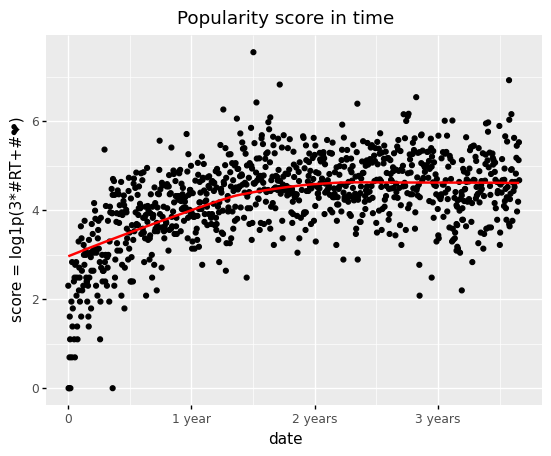

<ggplot: (8778932925573)>

In [69]:
p = ggplot(aes(x='days', y='score'), df2)
p + geom_point() + geom_smooth(color="red") + labs(title="Popularity score in time") + ylab("score = log1p(3*#RT+#❤️)") + xlab("date")

Manual smoothing

In [84]:
lowess = sm.nonparametric.lowess

df2['days2'] = (df2['created_at'].array - df2['created_at'].array[-1]).days
smoothed = lowess(df2.score, df2.days2)

assert (df2['days2'].array == smoothed[:,0][::-1]).all()
df2['smoothed_score'] = smoothed[:,1][::-1]
df2['smoothed_score_plus'] = smoothed[:,1][::-1] + 1.0

/home/petr/.pyenv/versions/3.8.1/envs/pytips/lib/python3.8/site-packages/plotnine/stats/smoothers.py:310: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.
/home/petr/.pyenv/versions/3.8.1/envs/pytips/lib/python3.8/site-packages/plotnine/stats/smoothers.py:310: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.


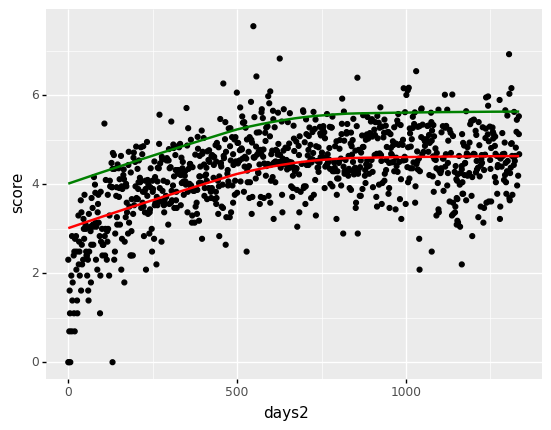

<ggplot: (8778932974517)>

In [85]:
p = ggplot(aes(x='days2', y='score'), df2)
p + geom_point() + geom_smooth(aes(x='days2', y='smoothed_score'), color="red") + geom_smooth(aes(x='days2', y='smoothed_score_plus'), color="green")

In [79]:
df3 = df2[df2.score > df2.smoothed_score].copy()
df3.shape

(491, 13)

In [83]:
df4 = df2[df2.score > df2.smoothed_score + 1.0].copy()
df4.shape

(73, 13)

In [86]:
df3.to_csv("df3.csv")
df4.to_csv("df4.csv")